## Entropy Weighted Image Gradient

Based on this paper
https://rpm.snu.ac.kr/publications/jwkim-2018-icra.pdf

In [236]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def calc_entropy_map(image, neighborhood_size=9):
    pad_size = neighborhood_size // 2
    image = cv2.copyMakeBorder(image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_REFLECT)
    entropy_image = np.zeros_like(image, dtype=float)

    for i in range(pad_size, image.shape[0] - pad_size):
        for j in range(pad_size, image.shape[1] - pad_size):
            neighborhood = image[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]
            hist = cv2.calcHist([neighborhood], [0], None, [256], [0,256])
            hist /= neighborhood.size
            entropy = -np.sum(hist * np.log2(hist + np.finfo(float).eps))
            entropy_image[i, j] = entropy

    entropy_image = entropy_image[pad_size:-pad_size, pad_size:-pad_size]
    return entropy_image

def calculate_weights(entropy_image):
    mean_entropy = np.mean(entropy_image)
    variance = np.var(entropy_image)
    weights = 1 / variance * np.exp(- (entropy_image - mean_entropy)**2 / (2 * variance**2))
    return weights

def calculate_gradient(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return magnitude

def calculate_saturation_mask(entropy_image, Hthres=0.05):
    saturation_mask = np.zeros_like(entropy_image)
    saturation_mask[entropy_image < Hthres] = 1
    return saturation_mask

def activation_function(M, alpha, tau):
    pi = 2 / (1 + np.exp(-alpha * M + tau)) - 1
    return pi

Implementing Block Diagram

In [241]:
img = cv2.imread('ss_20230707113143.png')
resize_factor = 10
img = cv2.resize(img, (img.shape[1] // resize_factor,img.shape[0] // resize_factor))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Compute entropy and gradient
entropy_image = calc_entropy_map(gray, 9)
magnitude = calculate_gradient(gray)

# Weights then normalise
W = calculate_weights(entropy_image)
W = W / np.sum(W)

# Compute satuation mask
M = calculate_saturation_mask(entropy_image)

#  Activation function
alpha = 64
tau = 4
pi = activation_function(entropy_image, alpha, tau)

# Entropy weighted gradient
gi = W * magnitude + pi * M * W * np.mean(magnitude)

print(np.sum(gi))

34.52486832772243


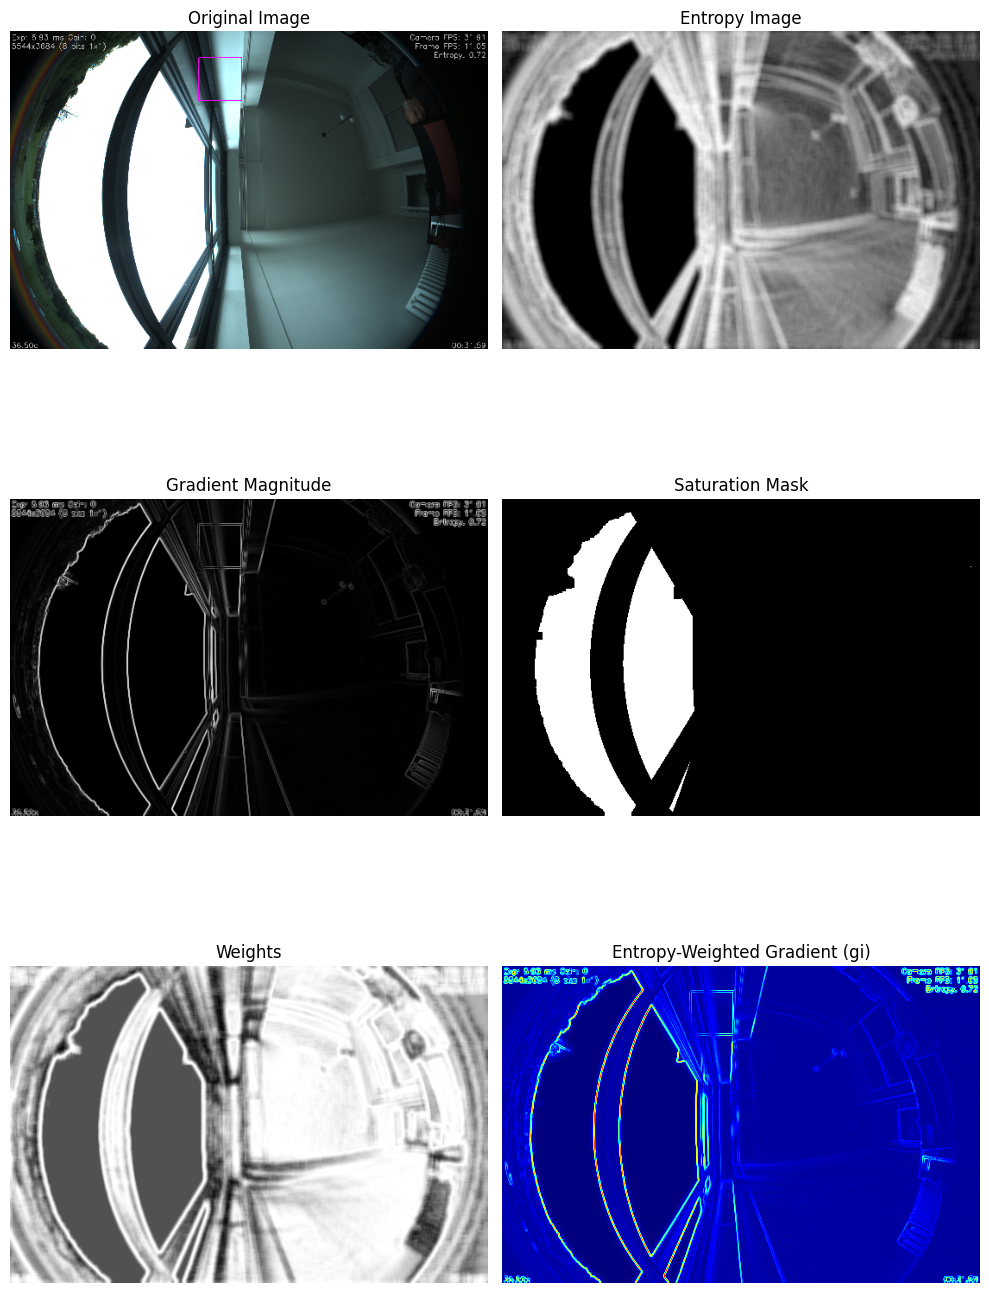

In [238]:
# Create a figure with 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

# Plot the original image
axs[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Plot the entropy image
axs[0, 1].imshow(entropy_image, cmap='gray')
axs[0, 1].set_title('Entropy Image')
axs[0, 1].axis('off')

# Plot the magnitude of the gradient
axs[1, 0].imshow(magnitude, cmap='gray')
axs[1, 0].set_title('Gradient Magnitude')
axs[1, 0].axis('off')

# Plot the saturation mask
axs[1, 1].imshow(M, cmap='gray')
axs[1, 1].set_title('Saturation Mask')
axs[1, 1].axis('off')

# Plot the weights
axs[2, 0].imshow(W, cmap='gray')
axs[2, 0].set_title('Weights')
axs[2, 0].axis('off')

# Plot gi
axs[2, 1].imshow(gi, cmap='jet')
axs[2, 1].set_title('Entropy-Weighted Gradient (gi)')
axs[2, 1].axis('off')

# Display the plots
plt.tight_layout()
plt.show()